# Supplementary Figure 1. Wolbachia fitness sensitivity analysis
Author: Katie Tiley (katherine.tiley@lshtm.ac.uk) <br>
Date: 08 Nov 22

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import chain

### 1. Set up model
Parameters:

In [17]:
# MOSQUITO
alphaO = 0.5  # rate that eggs hatch into larvae
alphaL = 0.18  # rate that larvae pupate
alphaP = 1  # rate that pupae eclose
phi = 500*(1/14)    # number eggs laid per mosquito per day
muO = 0.01    # daily death rate of eggs
muL = 0.1*alphaL    # daily death rate of larvae
muP = 0.1*alphaP     # pupae death rate
muM = 1/14     # adult mosquito death rate
muF = 1/14     # adult female mosquito death rate

# density-dependence via Bellows 1981:
AA = 1   # determines the density at which mortality remains proportionate
BB = 0.5   # determines the 'abruptness' of density-dependence

# WOLBACHIA
fCI = 0.012   # prop of cytoplasmic incompatibility that fails 'sigma'
MT = 0    # prop of wolbachia females that don't successfully maternally transfer 'omega'
c = 0.5      # mating competitiveness of released wolbachia males
e = 1.2      # relative mortality of wolbachia adults compared to wild adults
RR = 1       # release ratio of wolbachia eggs to wild type eggs

Initial conditions:
(equilibrium values previously defined in Supp)

In [18]:
O0 = 15947.608023052446
OW0 = 0
rOW0 = 0
L0 = 40271.71074193975
LW0 = 0
rLW0 = 0
P0 = 32.67541200187585
PW0 = 0
rPW0 = 0
M0 = 228.72754035145144
MW0 = 0
F0 = 228.72754035145144
FW0 = 0

Wolbachia release function:

In [19]:
fN = 14                        #frequency of new Wol release
start_N = 139                   #day to first deploy Wol 
stop_N = 253 #330                   #stop deploying wolbachia - 253 is 9 releases, 330 is 14 releases

def pulseN(t):
    if round(t) < start_N:     #start releases
        return 0
    elif round(t) % fN > 0:    #do it every fN days i.e. if modulus is anything but zero do nothing
        return 0
    elif round(t) > stop_N:    #stop releases
        return 0
    else:
        return O0 #15947.608023052446 #equilibrium

In [29]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=5, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return O0
    else:
        return 0

Wolbachia model:

In [20]:
def deriv(y, t, fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN):
    
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = y
    
    #MOSQUITOES
    
    allmales = 1+M+MW
    
    F_nothing = F + FW*MT 
    M_nothing = M + MW*fCI 
    
    F_wol = FW*(1-MT)
    
    #Eggs
    dOdt = phi * F_nothing * M_nothing/allmales - alphaO*O - muO*O
    # eggs laid * females no-wol * (males no_wol / all males) (aka prop no-wol males)
    dOWdt = phi * F_wol - alphaO*OW - muO*OW 
    drOWdt = pulseN(t)*RR - alphaO*rOW - muO*rOW 
        
    #Larvae
    dLdt =  alphaO*O - alphaL*L - muL*L 
    dLWdt = alphaO*OW - alphaL*LW - muL*LW
    drLWdt = alphaO*rOW - alphaL*rLW - muL*rLW
    
    #Pupae
    dPdt =  alphaL*(L/(1+((AA*(L+LW))**BB))) - alphaP*P - muP*P 
    dPWdt = alphaL*(LW/(1+((AA*(L+LW))**BB))) - alphaP*PW - muP*PW
    drPWdt = alphaL*(rLW/(1+((AA*(rLW))**BB))) - alphaP*rPW - muP*rPW 
    
    #Adult
    dMdt = 0.5*alphaP*P - muM*M
    dMWdt = 0.5*alphaP*(PW+rPW) - muM*MW*e
    
    dFdt = 0.5*alphaP*P - muF*F
    dFWdt = 0.5*alphaP*(PW+rPW) - muF*FW*e  

    return dOdt, dOWdt, drOWdt, dLdt, dLWdt, drLWdt, dPdt, dPWdt, drPWdt,  dMdt, dMWdt, dFdt, dFWdt

Model prerequisites:

In [30]:
t = np.linspace(0, 1500, 1501) # grid of time points (in days)
y0 = O0, OW0, rOW0, L0, LW0, rLW0, P0, PW0, rPW0, M0, MW0, F0, FW0 # initial condition vector

In [31]:
ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)

O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T

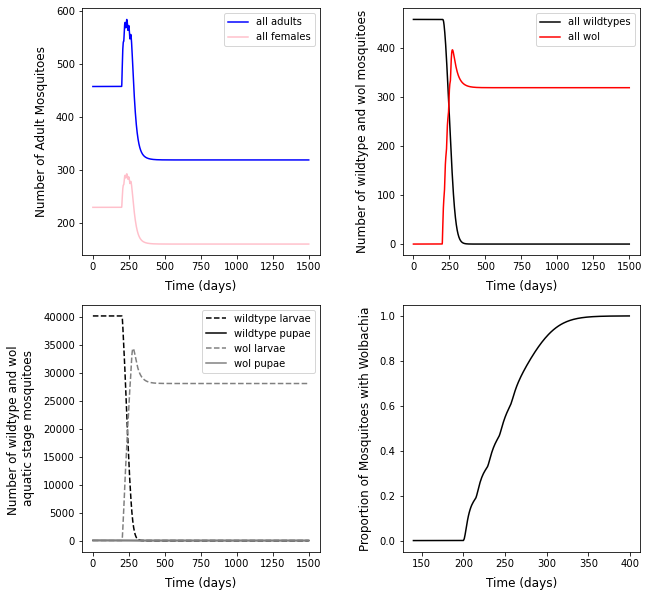

In [32]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10,10])

ax1.plot(t, F+FW+M+MW, 'blue', label='all adults')
ax1.plot(t, F+FW, 'pink', label='all females')
ax1.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax1.set_ylabel("Number of Adult Mosquitoes",fontsize=12, labelpad=8)
ax1.legend()

ax2.plot(t, M+F, 'black', label='all wildtypes')
ax2.plot(t, MW+FW, 'red', label='all wol')
ax2.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax2.set_ylabel("Number of wildtype and wol mosquitoes",fontsize=12, labelpad=8)
ax2.legend()

ax3.plot(t, L, 'black', linestyle='dashed', label='wildtype larvae')
ax3.plot(t, P, 'black', label='wildtype pupae')
ax3.plot(t, LW, 'grey', linestyle='dashed', label='wol larvae')
ax3.plot(t, PW, 'grey', label='wol pupae')
ax3.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax3.set_ylabel("Number of wildtype and wol \naquatic stage mosquitoes",fontsize=12, labelpad=8)
ax3.legend()

ax4.plot(t[140:400], (MW[140:400]+FW[140:400])/(MW[140:400]+FW[140:400]+M[140:400]+F[140:400]), 'black')
plt.xticks([150,200,250,300,350,400])
ax4.set_xlabel("Time (days)",fontsize=12, labelpad=8)
ax4.set_ylabel("Proportion of Mosquitoes with Wolbachia",fontsize=12, labelpad=8)


plt.subplots_adjust(wspace=.35)

### 2. Panels A & B; population dynamics of 9 and 14 releases
Run model:

In [47]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=9, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return O0
    else:
        return 0

In [48]:
# 9 RELEASES, adultRR of 0.05 across range of Wol fitness cost of 0%, 5%, 10%, 15%, 20%, 25%, 30%

fix9 = []
bump9 = [["Release number","Population increase"]]
pop9 = []
e_vec = [1,1.05,1.1,1.15,1.2,1.25,1.3]

for j in e_vec: #j is wol fitness cost
    e = j
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    wildtotal = M+F
    total = MW+FW+M+F
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95) #time of fixation from start of model
    y = M[z]+MW[z]+F[z]+FW[z] #total population at time of fixation
    
    popeq = M[0]+MW[0]+F[0]+FW[0] 
    popmax = max(M+MW+F+FW)
    bump = popmax-popeq
    
    fix9.append((z,y))
    bump9.append([j,bump])
    pop9.append(total)
    
fix9days = [] #time of fixation from first release
for j in range(0,len(fix9)):
    fix9days.append(fix9[j][0] - 140)

Plot:

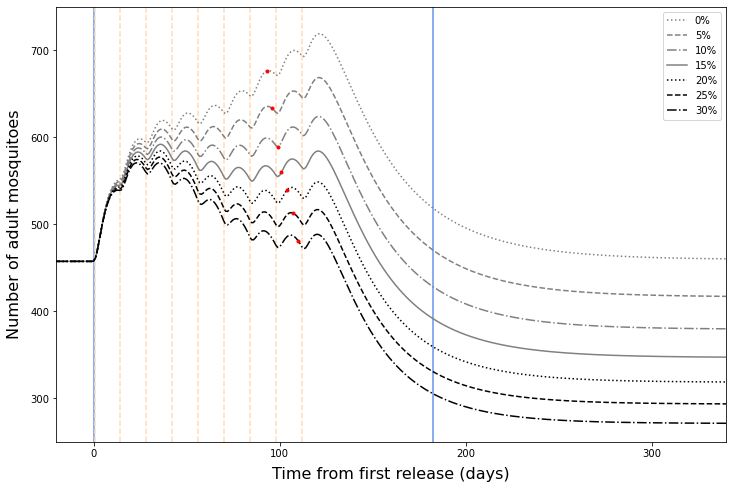

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.margins(x=0, y=0)
plt.axvline(x=200, color="cornflowerblue", linestyle="solid")
plt.axvline(x=382.5, color="cornflowerblue", linestyle="solid")
plt.axvline(x=565, color="cornflowerblue", linestyle="solid")
plt.axvline(x=200+1, color="peachpuff", linestyle="dashed")
plt.axvline(x=214, color="peachpuff", linestyle="dashed")
plt.axvline(x=228, color="peachpuff", linestyle="dashed")
plt.axvline(x=242, color="peachpuff", linestyle="dashed")
plt.axvline(x=256, color="peachpuff", linestyle="dashed")
plt.axvline(x=270, color="peachpuff", linestyle="dashed")
plt.axvline(x=284, color="peachpuff", linestyle="dashed")
plt.axvline(x=298, color="peachpuff", linestyle="dashed")
plt.axvline(x=312, color="peachpuff", linestyle="dashed")
ax.plot(t, pop9[0], 'grey', linestyle='dotted', label='0%')
ax.plot(fix9[0][0], fix9[0][1], marker=".", color="red")
ax.plot(t, pop9[1], 'grey', linestyle='dashed', label='5%')
ax.plot(fix9[1][0], fix9[1][1], marker=".", color="red")
ax.plot(t, pop9[2], 'grey', linestyle='dashdot', label='10%')
ax.plot(fix9[2][0], fix9[2][1], marker=".", color="red")
ax.plot(t, pop9[3], 'grey', linestyle='solid', label='15%')
ax.plot(fix9[3][0], fix9[3][1], marker=".", color="red")
ax.plot(t, pop9[4], 'black', linestyle='dotted', label='20%')
ax.plot(fix9[4][0], fix9[4][1], marker=".", color="red")
ax.plot(t, pop9[5], 'black', linestyle='dashed', label='25%')
ax.plot(fix9[5][0], fix9[5][1], marker=".", color="red")
ax.plot(t, pop9[6], 'black', linestyle='dashdot', label='30%')
ax.plot(fix9[6][0], fix9[6][1], marker=".", color="red")

positions1 = (200, 300, 400, 500, 600)
labels1 = ("0", "100", "200", "300", "400")
plt.xticks(positions1, labels1)
ax.set_xlim([180, 540])
ax.set_ylim([250, 750])
ax.set_xlabel("Time from first release (days)", fontsize=16, labelpad=8)
ax.set_ylabel("Number of adult mosquitoes", fontsize=16, labelpad=8)
ax.legend(loc = 'upper right')
#ax.set_title("Nine Releases")

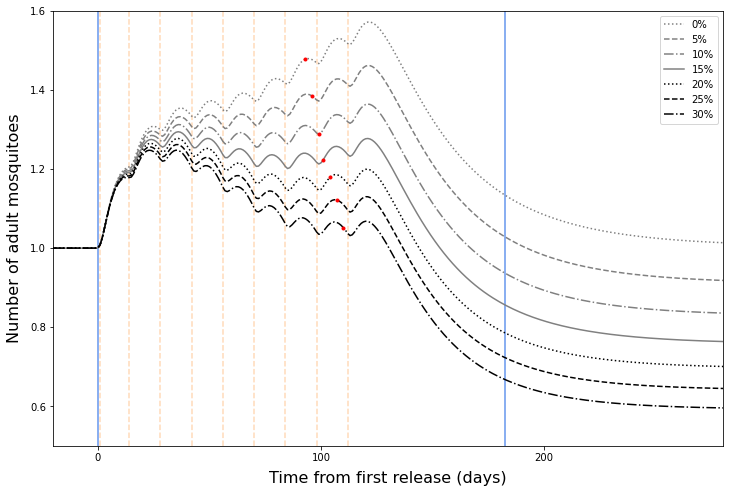

In [60]:
# ALTERNATE y-axis proportional to no control

equilibrium = 457.4550807029029

fig, ax = plt.subplots(figsize=(12, 8))

plt.margins(x=0, y=0)
plt.axvline(x=200, color="cornflowerblue", linestyle="solid")
plt.axvline(x=382.5, color="cornflowerblue", linestyle="solid")
plt.axvline(x=565, color="cornflowerblue", linestyle="solid")
plt.axvline(x=200+1, color="peachpuff", linestyle="dashed")
plt.axvline(x=214, color="peachpuff", linestyle="dashed")
plt.axvline(x=228, color="peachpuff", linestyle="dashed")
plt.axvline(x=242, color="peachpuff", linestyle="dashed")
plt.axvline(x=256, color="peachpuff", linestyle="dashed")
plt.axvline(x=270, color="peachpuff", linestyle="dashed")
plt.axvline(x=284, color="peachpuff", linestyle="dashed")
plt.axvline(x=298, color="peachpuff", linestyle="dashed")
plt.axvline(x=312, color="peachpuff", linestyle="dashed")
ax.plot(t, pop9[0]/equilibrium, 'grey', linestyle='dotted', label='0%')
ax.plot(fix9[0][0], fix9[0][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[1]/equilibrium, 'grey', linestyle='dashed', label='5%')
ax.plot(fix9[1][0], fix9[1][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[2]/equilibrium, 'grey', linestyle='dashdot', label='10%')
ax.plot(fix9[2][0], fix9[2][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[3]/equilibrium, 'grey', linestyle='solid', label='15%')
ax.plot(fix9[3][0], fix9[3][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[4]/equilibrium, 'black', linestyle='dotted', label='20%')
ax.plot(fix9[4][0], fix9[4][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[5]/equilibrium, 'black', linestyle='dashed', label='25%')
ax.plot(fix9[5][0], fix9[5][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop9[6]/equilibrium, 'black', linestyle='dashdot', label='30%')
ax.plot(fix9[6][0], fix9[6][1]/equilibrium, marker=".", color="red")

positions1 = (200, 300, 400, 500, 600)
labels1 = ("0", "100", "200", "300", "400")
plt.xticks(positions1, labels1)
ax.set_xlim([180, 480])
ax.set_ylim([0.5, 1.6])
ax.set_xlabel("Time from first release (days)", fontsize=16, labelpad=8)
ax.set_ylabel("Number of adult mosquitoes", fontsize=16, labelpad=8)
ax.legend(loc = 'upper right')
#ax.set_title("Nine Releases")

Run model:

In [68]:
start_wol = 200

def pulseN(t, start_wol=start_wol, releasenumber=14, frequency=14):    
    for i in range(0,releasenumber,1):
        if round(t) == start_wol + (frequency*i):
            return O0
    else:
        return 0

In [69]:
# 14 RELEASES, adultRR of 0.05 across range of Wol fitness cost of 0%, 5%, 10%, 15%, 20%, 25%, 30%


fix14 = []
bump14 = [["Release number","Population increase"]]
pop14 = []
e_vec = [1,1.05,1.1,1.15,1.2,1.25,1.3]

for j in e_vec: #j is wol fitness cost
    e = j
    ret = odeint(deriv, y0, t,args=(fCI, MT, c, e, phi, alphaO, muO, AA, BB, alphaL, alphaP, muP, muM, muF, RR, pulseN),hmax=1)
    O, OW, rOW, L, LW, rLW, P, PW, rPW, M, MW, F, FW = ret.T
    
    wildtotal = M+F
    total = MW+FW+M+F
    
    Prop = (MW+FW)/(MW+FW+M+F)
    z = next(x[0] for x in enumerate(Prop) if x[1] > 0.95) #time of fixation from start of model
    y = M[z]+MW[z]+F[z]+FW[z] #total population at time of fixation
    
    popeq = M[0]+MW[0]+F[0]+FW[0] 
    popmax = max(M+MW+F+FW)
    bump = popmax-popeq
    
    fix14.append((z,y))
    bump14.append([j,bump])
    pop14.append(total)
    
fix14days = [] #time of fixation from first release
for j in range(0,len(fix14)):
    fix14days.append(fix14[j][0] - 140)

Plot:

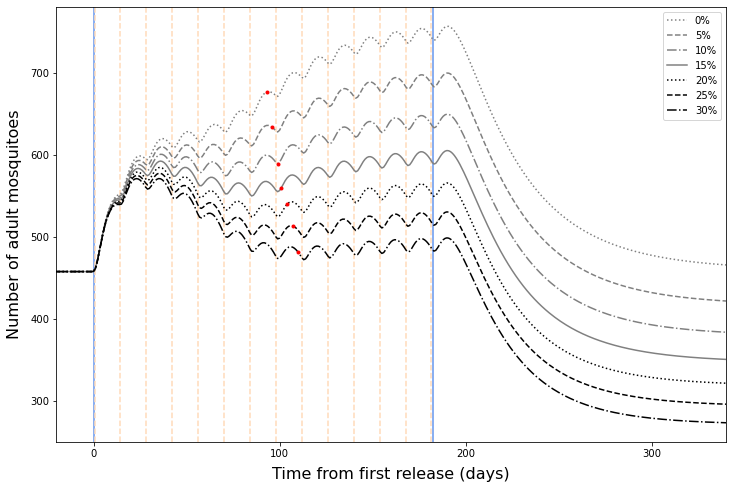

In [76]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.margins(x=0, y=0)
plt.axvline(x=200, color="cornflowerblue", linestyle="solid")
plt.axvline(x=382.5, color="cornflowerblue", linestyle="solid")
plt.axvline(x=565, color="cornflowerblue", linestyle="solid")
plt.axvline(x=200+1, color="peachpuff", linestyle="dashed")
plt.axvline(x=214, color="peachpuff", linestyle="dashed")
plt.axvline(x=228, color="peachpuff", linestyle="dashed")
plt.axvline(x=242, color="peachpuff", linestyle="dashed")
plt.axvline(x=256, color="peachpuff", linestyle="dashed")
plt.axvline(x=270, color="peachpuff", linestyle="dashed")
plt.axvline(x=284, color="peachpuff", linestyle="dashed")
plt.axvline(x=298, color="peachpuff", linestyle="dashed")
plt.axvline(x=312, color="peachpuff", linestyle="dashed")
plt.axvline(x=326, color="peachpuff", linestyle="dashed")
plt.axvline(x=340, color="peachpuff", linestyle="dashed")
plt.axvline(x=354, color="peachpuff", linestyle="dashed")
plt.axvline(x=368, color="peachpuff", linestyle="dashed")
plt.axvline(x=382.5-1, color="peachpuff", linestyle="dashed")
ax.plot(t, pop14[0], 'grey', linestyle='dotted', label='0%')
ax.plot(fix14[0][0], fix14[0][1], marker=".", color="red")
ax.plot(t, pop14[1], 'grey', linestyle='dashed', label='5%')
ax.plot(fix14[1][0], fix14[1][1], marker=".", color="red")
ax.plot(t, pop14[2], 'grey', linestyle='dashdot', label='10%')
ax.plot(fix14[2][0], fix14[2][1], marker=".", color="red")
ax.plot(t, pop14[3], 'grey', linestyle='solid', label='15%')
ax.plot(fix14[3][0], fix14[3][1], marker=".", color="red")
ax.plot(t, pop14[4], 'black', linestyle='dotted', label='20%')
ax.plot(fix14[4][0], fix14[4][1], marker=".", color="red")
ax.plot(t, pop14[5], 'black', linestyle='dashed', label='25%')
ax.plot(fix14[5][0], fix14[5][1], marker=".", color="red")
ax.plot(t, pop14[6], 'black', linestyle='dashdot', label='30%')
ax.plot(fix14[6][0], fix14[6][1], marker=".", color="red")

positions1 = (200, 300, 400, 500, 600)
labels1 = ("0", "100", "200", "300", "400")
plt.xticks(positions1, labels1)
ax.set_xlim([180, 540])
ax.set_ylim([250, 780])
ax.set_xlabel("Time from first release (days)", fontsize=16, labelpad=8)
ax.set_ylabel("Number of adult mosquitoes", fontsize=16, labelpad=8)
ax.legend(loc = 'upper right')
#ax.set_title("Fourteen Releases")

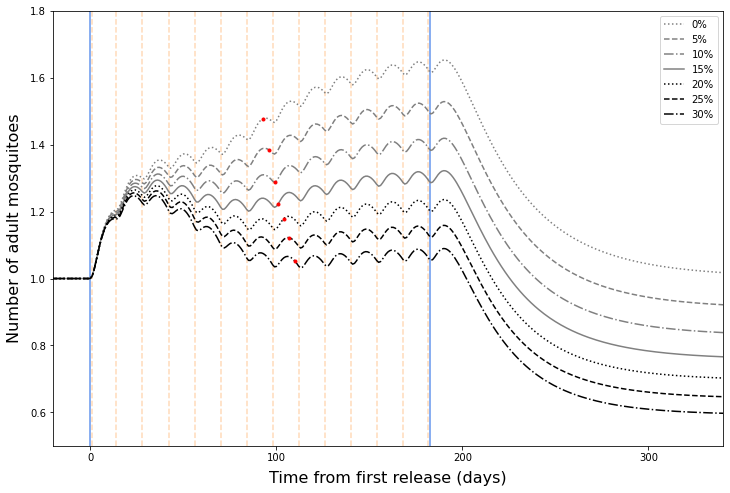

In [77]:
# ALTERNATE y-axis proportional to no control

equilibrium = 457.4550807029029

fig, ax = plt.subplots(figsize=(12, 8))

plt.margins(x=0, y=0)
plt.axvline(x=200, color="cornflowerblue", linestyle="solid")
plt.axvline(x=382.5, color="cornflowerblue", linestyle="solid")
plt.axvline(x=565, color="cornflowerblue", linestyle="solid")
plt.axvline(x=200+1, color="peachpuff", linestyle="dashed")
plt.axvline(x=214, color="peachpuff", linestyle="dashed")
plt.axvline(x=228, color="peachpuff", linestyle="dashed")
plt.axvline(x=242, color="peachpuff", linestyle="dashed")
plt.axvline(x=256, color="peachpuff", linestyle="dashed")
plt.axvline(x=270, color="peachpuff", linestyle="dashed")
plt.axvline(x=284, color="peachpuff", linestyle="dashed")
plt.axvline(x=298, color="peachpuff", linestyle="dashed")
plt.axvline(x=312, color="peachpuff", linestyle="dashed")
plt.axvline(x=326, color="peachpuff", linestyle="dashed")
plt.axvline(x=340, color="peachpuff", linestyle="dashed")
plt.axvline(x=354, color="peachpuff", linestyle="dashed")
plt.axvline(x=368, color="peachpuff", linestyle="dashed")
plt.axvline(x=382.5-1, color="peachpuff", linestyle="dashed")
ax.plot(t, pop14[0]/equilibrium, 'grey', linestyle='dotted', label='0%')
ax.plot(fix14[0][0], fix14[0][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[1]/equilibrium, 'grey', linestyle='dashed', label='5%')
ax.plot(fix14[1][0], fix14[1][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[2]/equilibrium, 'grey', linestyle='dashdot', label='10%')
ax.plot(fix14[2][0], fix14[2][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[3]/equilibrium, 'grey', linestyle='solid', label='15%')
ax.plot(fix14[3][0], fix14[3][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[4]/equilibrium, 'black', linestyle='dotted', label='20%')
ax.plot(fix14[4][0], fix14[4][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[5]/equilibrium, 'black', linestyle='dashed', label='25%')
ax.plot(fix14[5][0], fix14[5][1]/equilibrium, marker=".", color="red")
ax.plot(t, pop14[6]/equilibrium, 'black', linestyle='dashdot', label='30%')
ax.plot(fix14[6][0], fix14[6][1]/equilibrium, marker=".", color="red")

positions1 = (200, 300, 400, 500, 600)
labels1 = ("0", "100", "200", "300", "400")
plt.xticks(positions1, labels1)
ax.set_xlim([180, 540])
ax.set_ylim([0.5, 1.8])
ax.set_xlabel("Time from first release (days)", fontsize=16, labelpad=8)
ax.set_ylabel("Number of adult mosquitoes", fontsize=16, labelpad=8)
ax.legend(loc = 'upper right')
#ax.set_title("Fourteen Releases")

### 3. Combine panels into one figure

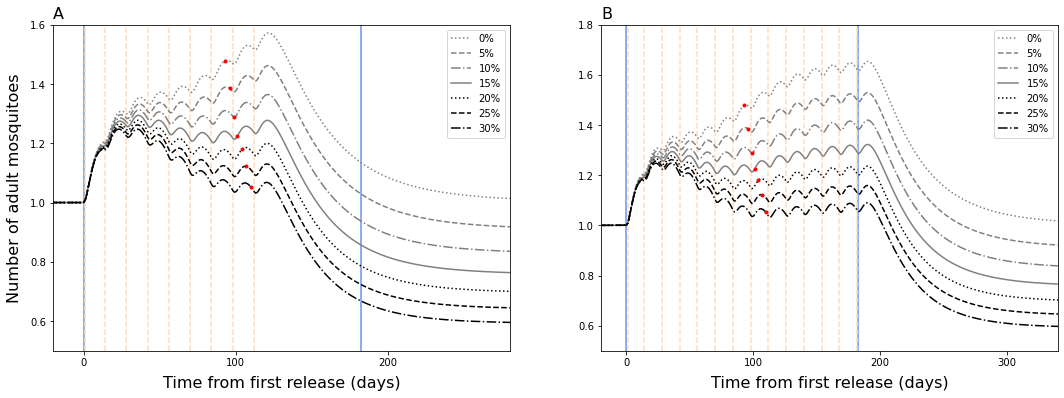

In [80]:
equilibrium = 457.4550807029029

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(18, 6))

ax1.axvline(x=200, color="cornflowerblue", linestyle="solid")
ax1.axvline(x=382.5, color="cornflowerblue", linestyle="solid")
ax1.axvline(x=565, color="cornflowerblue", linestyle="solid")
ax1.axvline(x=200+1, color="peachpuff", linestyle="dashed")
ax1.axvline(x=214, color="peachpuff", linestyle="dashed")
ax1.axvline(x=228, color="peachpuff", linestyle="dashed")
ax1.axvline(x=242, color="peachpuff", linestyle="dashed")
ax1.axvline(x=256, color="peachpuff", linestyle="dashed")
ax1.axvline(x=270, color="peachpuff", linestyle="dashed")
ax1.axvline(x=284, color="peachpuff", linestyle="dashed")
ax1.axvline(x=298, color="peachpuff", linestyle="dashed")
ax1.axvline(x=312, color="peachpuff", linestyle="dashed")
ax1.plot(t, pop9[0]/equilibrium, 'grey', linestyle='dotted', label='0%')
ax1.plot(fix9[0][0], fix9[0][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[1]/equilibrium, 'grey', linestyle='dashed', label='5%')
ax1.plot(fix9[1][0], fix9[1][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[2]/equilibrium, 'grey', linestyle='dashdot', label='10%')
ax1.plot(fix9[2][0], fix9[2][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[3]/equilibrium, 'grey', linestyle='solid', label='15%')
ax1.plot(fix9[3][0], fix9[3][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[4]/equilibrium, 'black', linestyle='dotted', label='20%')
ax1.plot(fix9[4][0], fix9[4][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[5]/equilibrium, 'black', linestyle='dashed', label='25%')
ax1.plot(fix9[5][0], fix9[5][1]/equilibrium, marker=".", color="red")
ax1.plot(t, pop9[6]/equilibrium, 'black', linestyle='dashdot', label='30%')
ax1.plot(fix9[6][0], fix9[6][1]/equilibrium, marker=".", color="red")

positions1 = (200, 300, 400, 500, 600)
labels1 = ("0", "100", "200", "300", "400")
ax1.set_xticks(positions1, labels1)
ax1.set_xlim([180, 480])
ax1.set_ylim([0.5, 1.6])
ax1.set_xlabel("Time from first release (days)", fontsize=16, labelpad=8)
ax1.set_ylabel("Number of adult mosquitoes", fontsize=16, labelpad=8)
ax1.legend(loc = 'upper right')
ax1.set_title("A", loc='left', fontdict={'fontsize':16})

#---------------------

ax2.axvline(x=200, color="cornflowerblue", linestyle="solid")
ax2.axvline(x=382.5, color="cornflowerblue", linestyle="solid")
ax2.axvline(x=565, color="cornflowerblue", linestyle="solid")
ax2.axvline(x=200+1, color="peachpuff", linestyle="dashed")
ax2.axvline(x=214, color="peachpuff", linestyle="dashed")
ax2.axvline(x=228, color="peachpuff", linestyle="dashed")
ax2.axvline(x=242, color="peachpuff", linestyle="dashed")
ax2.axvline(x=256, color="peachpuff", linestyle="dashed")
ax2.axvline(x=270, color="peachpuff", linestyle="dashed")
ax2.axvline(x=284, color="peachpuff", linestyle="dashed")
ax2.axvline(x=298, color="peachpuff", linestyle="dashed")
ax2.axvline(x=312, color="peachpuff", linestyle="dashed")
ax2.axvline(x=326, color="peachpuff", linestyle="dashed")
ax2.axvline(x=340, color="peachpuff", linestyle="dashed")
ax2.axvline(x=354, color="peachpuff", linestyle="dashed")
ax2.axvline(x=368, color="peachpuff", linestyle="dashed")
ax2.axvline(x=382.5-1, color="peachpuff", linestyle="dashed")
ax2.plot(t, pop14[0]/equilibrium, 'grey', linestyle='dotted', label='0%')
ax2.plot(fix14[0][0], fix14[0][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[1]/equilibrium, 'grey', linestyle='dashed', label='5%')
ax2.plot(fix14[1][0], fix14[1][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[2]/equilibrium, 'grey', linestyle='dashdot', label='10%')
ax2.plot(fix14[2][0], fix14[2][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[3]/equilibrium, 'grey', linestyle='solid', label='15%')
ax2.plot(fix14[3][0], fix14[3][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[4]/equilibrium, 'black', linestyle='dotted', label='20%')
ax2.plot(fix14[4][0], fix14[4][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[5]/equilibrium, 'black', linestyle='dashed', label='25%')
ax2.plot(fix14[5][0], fix14[5][1]/equilibrium, marker=".", color="red")
ax2.plot(t, pop14[6]/equilibrium, 'black', linestyle='dashdot', label='30%')
ax2.plot(fix14[6][0], fix14[6][1]/equilibrium, marker=".", color="red")

ax2.set_xticks(positions1, labels1)
ax2.set_xlim([180, 540])
ax2.set_ylim([0.5, 1.8])
ax2.set_xlabel("Time from first release (days)", fontsize=16, labelpad=8)
#ax.set_ylabel("Number of adult mosquitoes", fontsize=16, labelpad=8)
ax2.legend(loc = 'upper right')
ax2.set_title("B", loc='left', fontdict={'fontsize':16})

#plt.savefig('SFigure1_01-02-24.jpeg', bbox_inches='tight', dpi = 600)